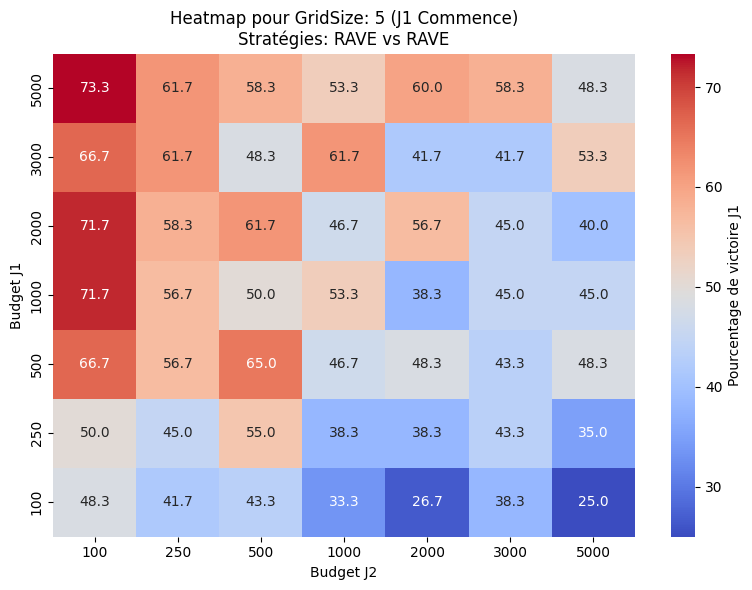

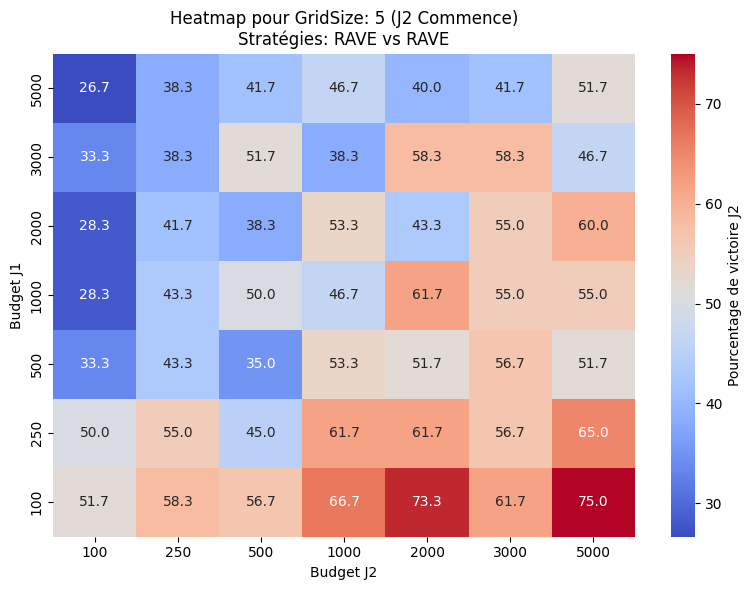

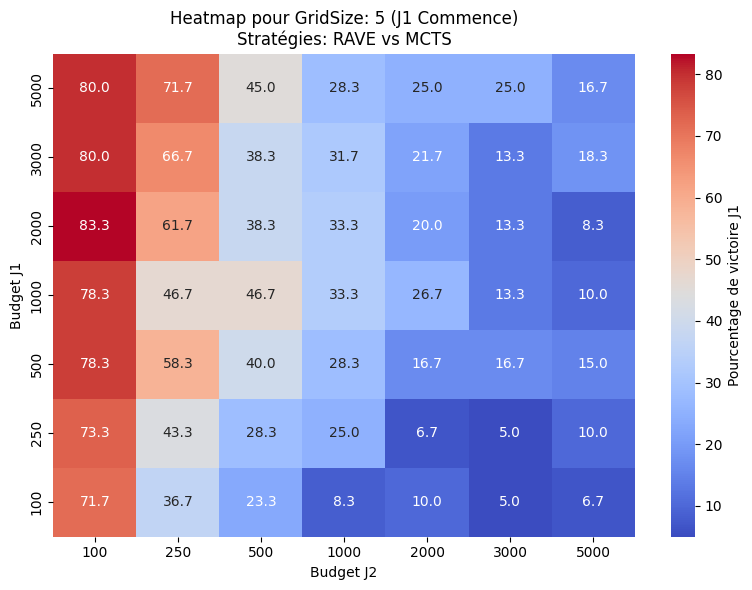

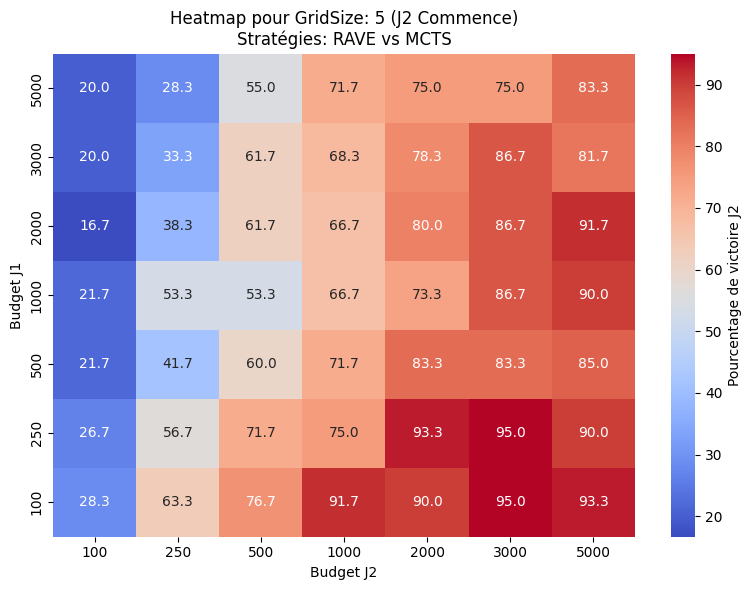

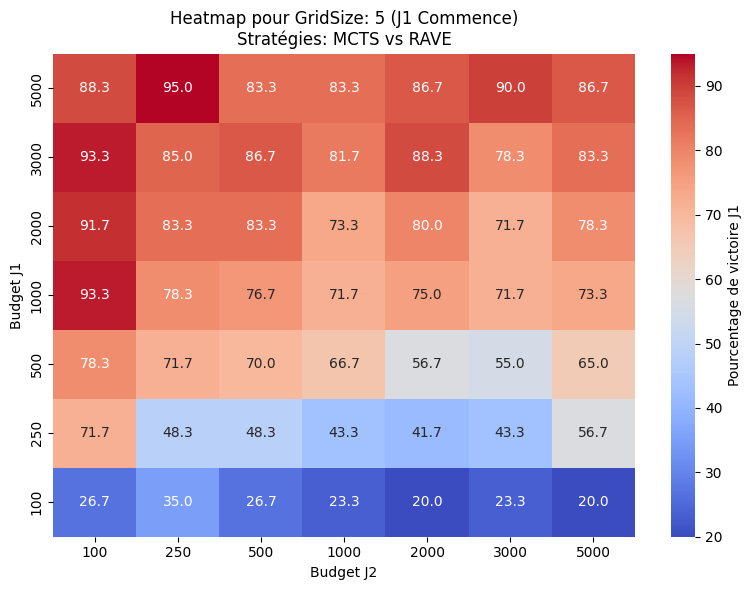

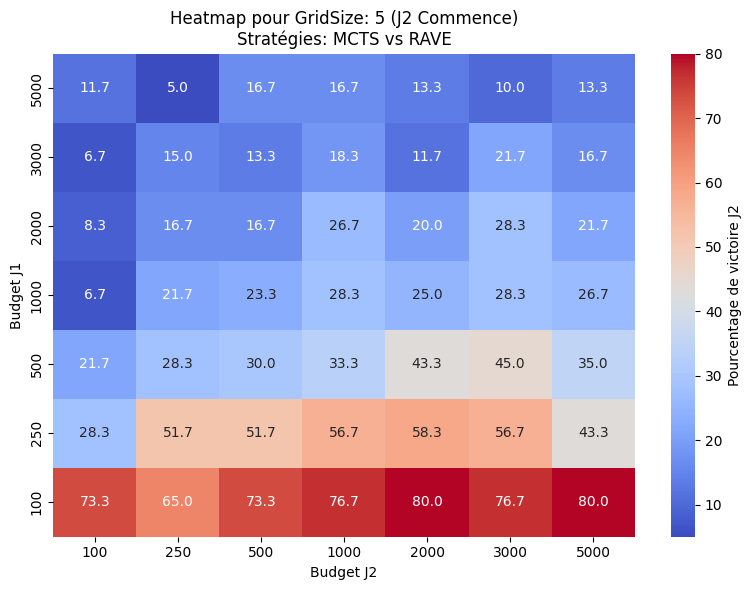

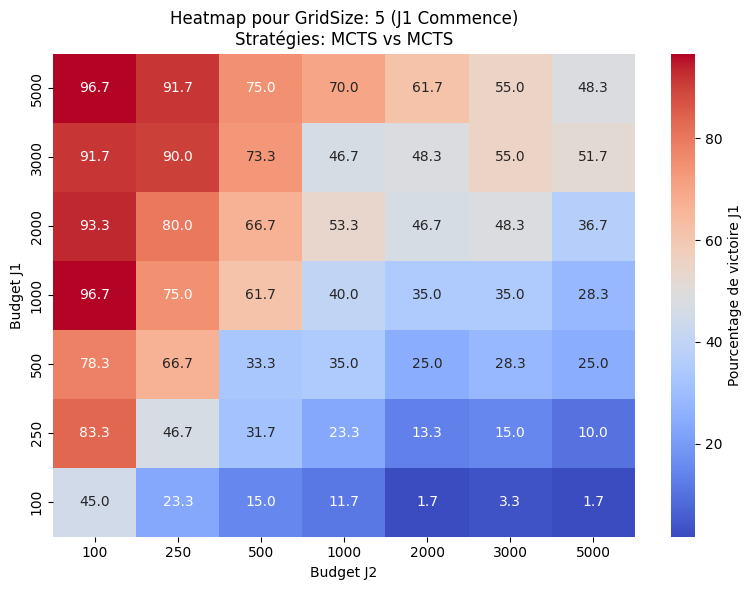

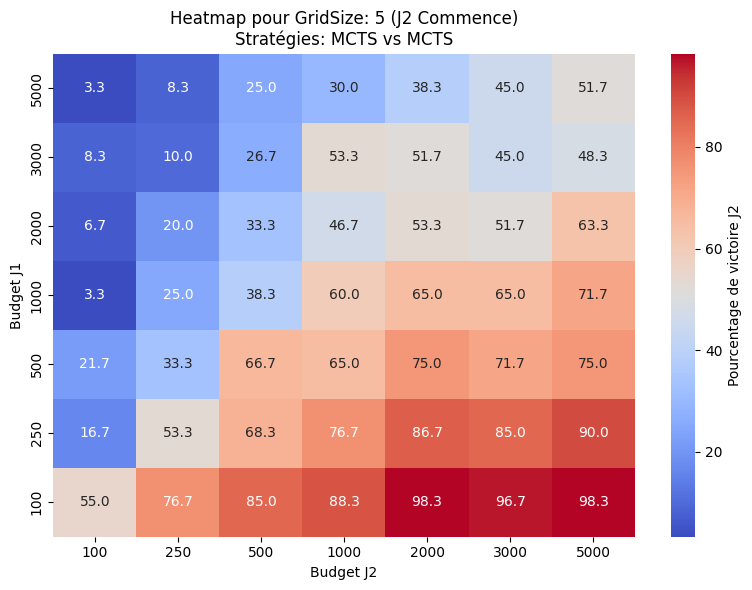

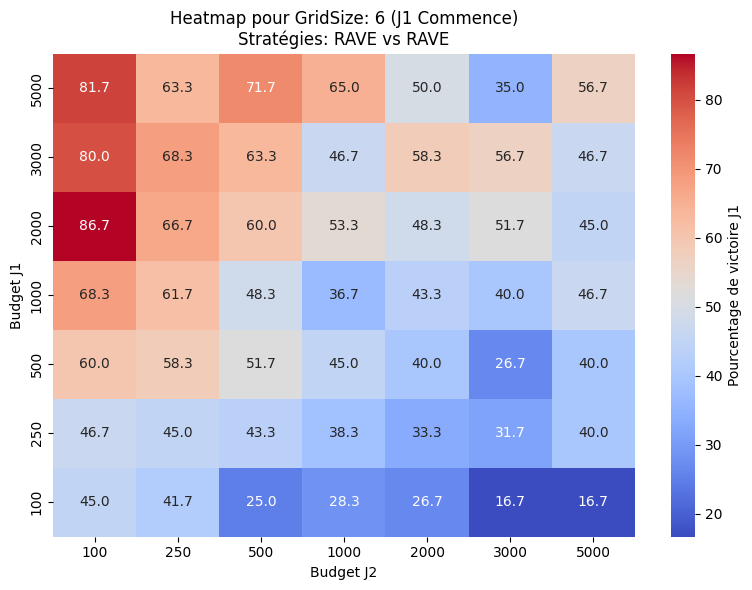

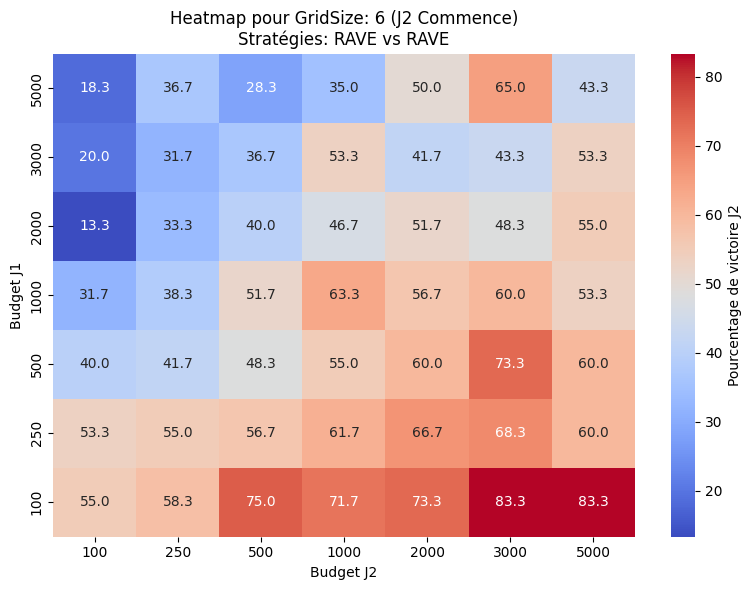

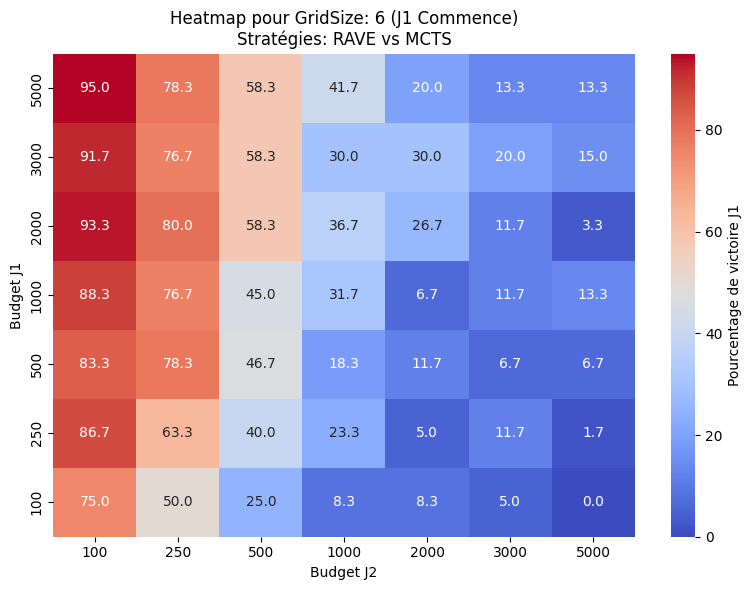

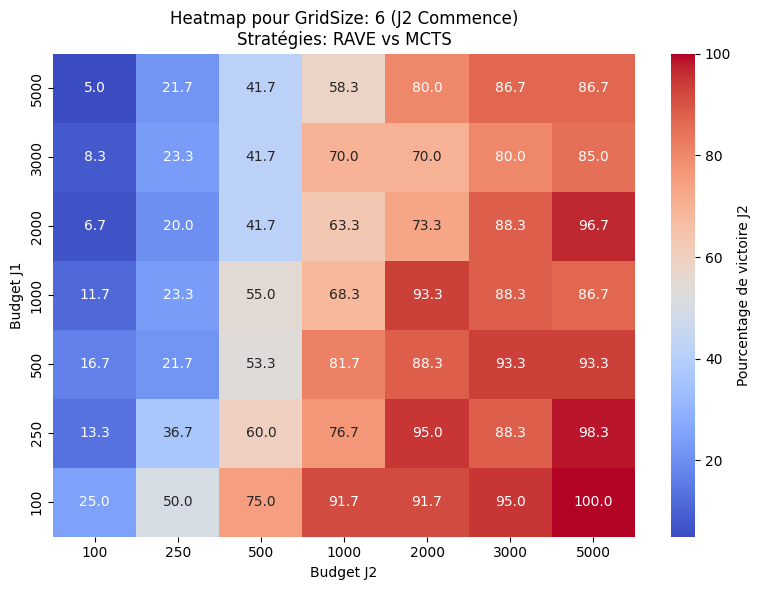

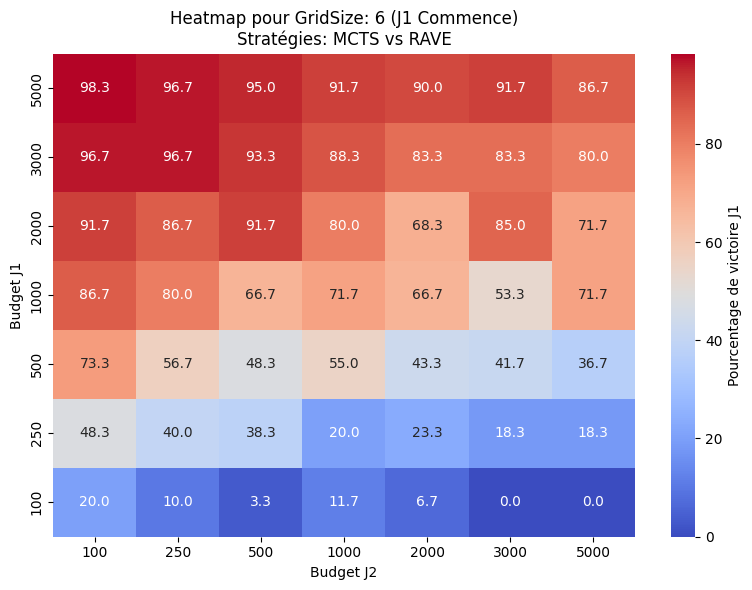

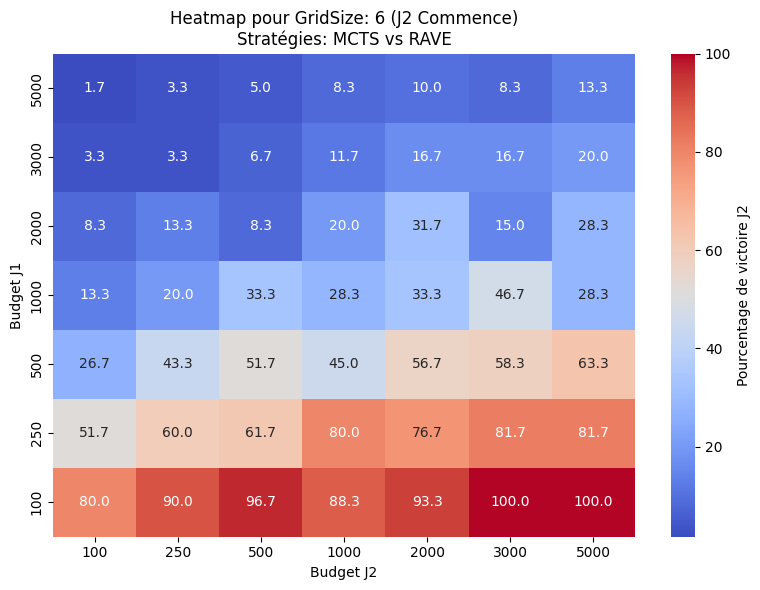

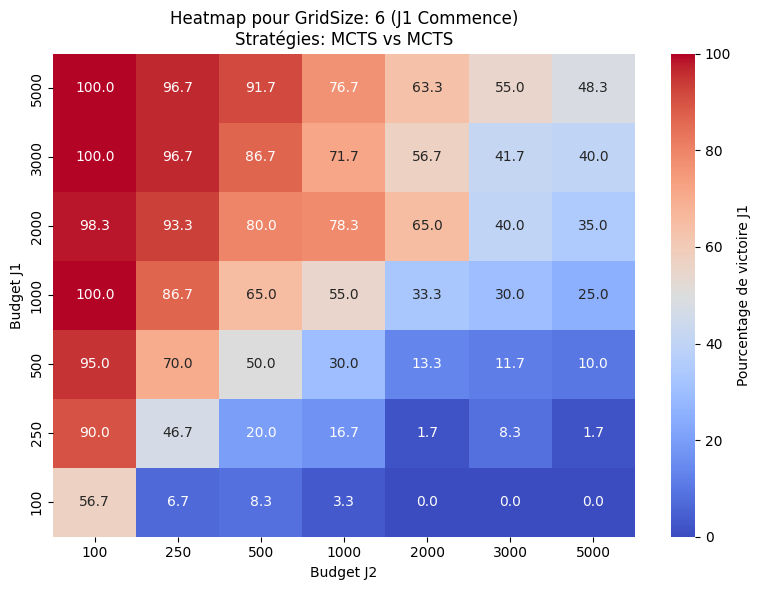

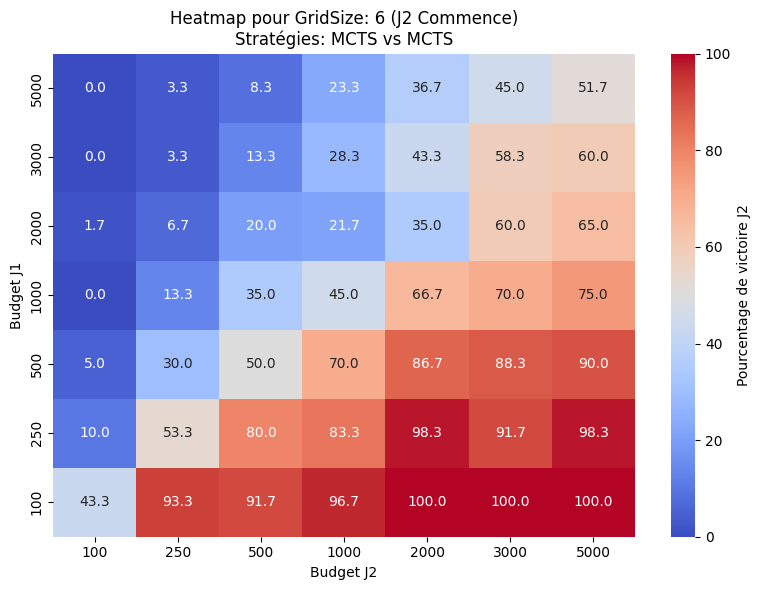

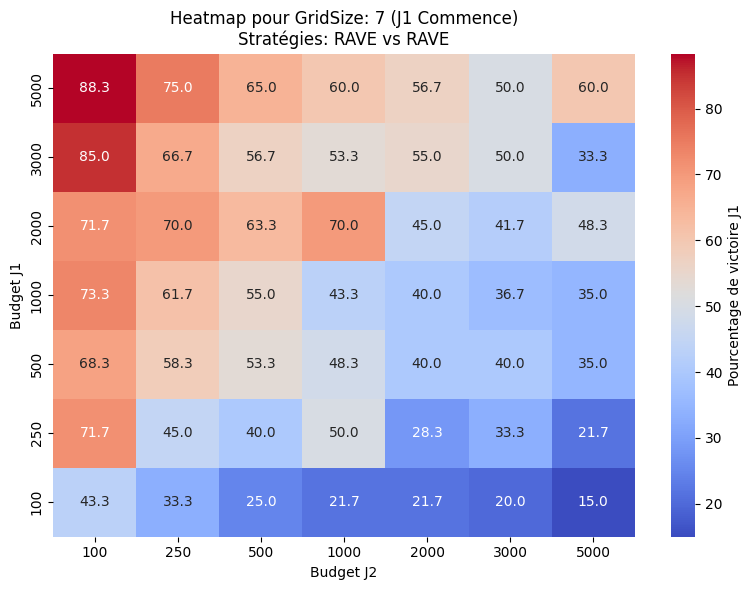

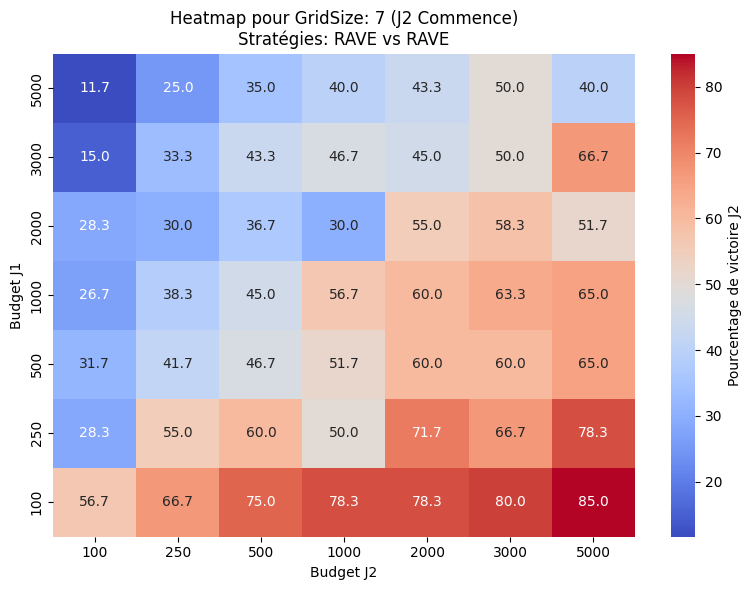

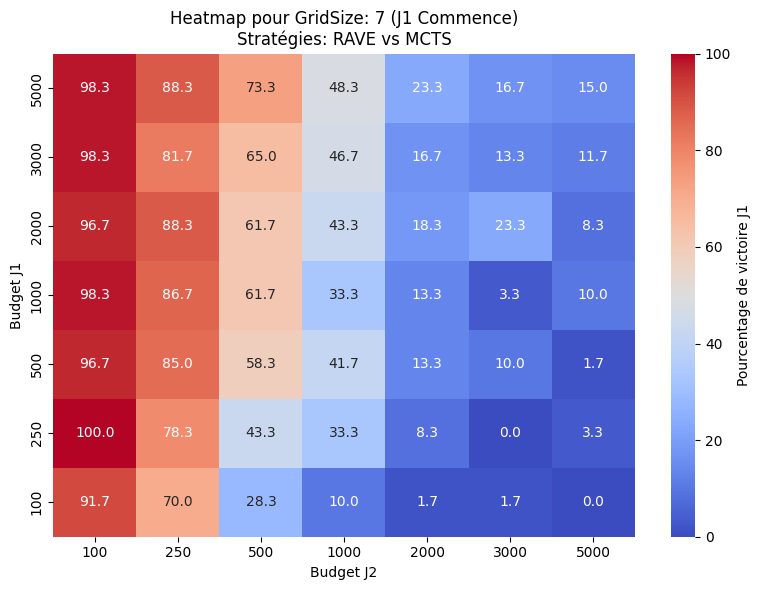

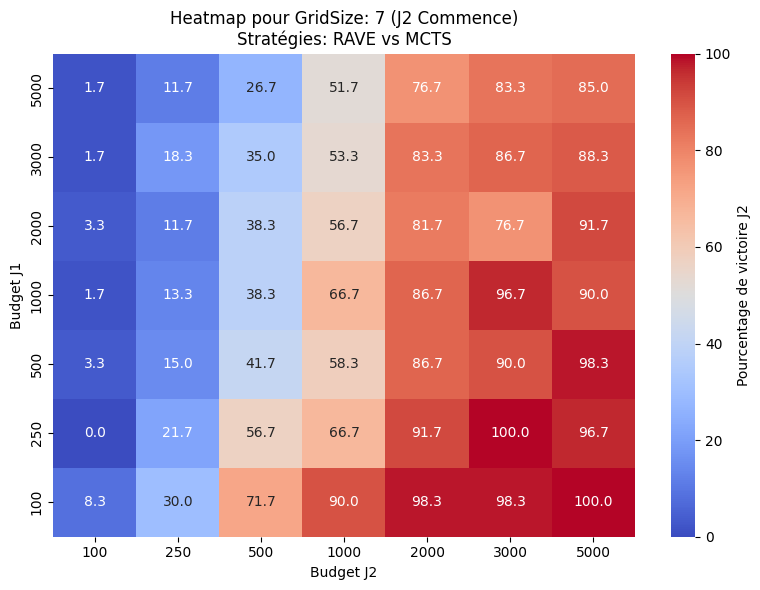

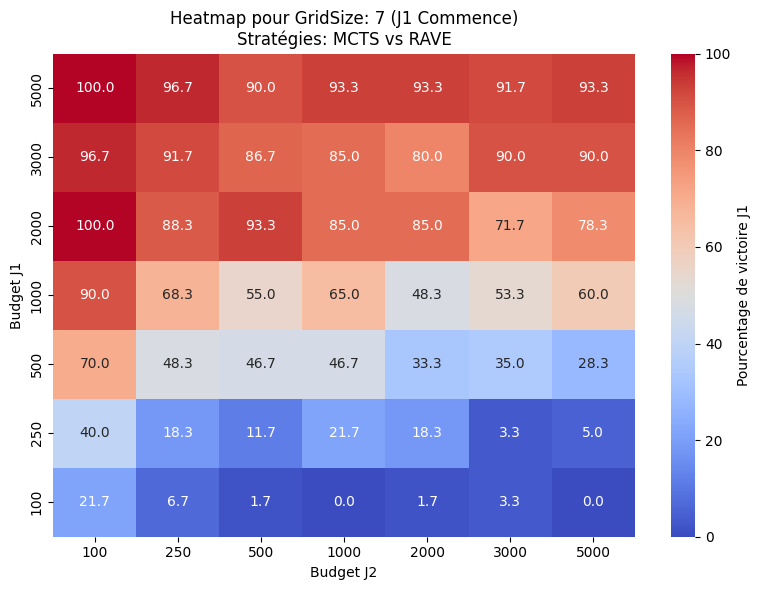

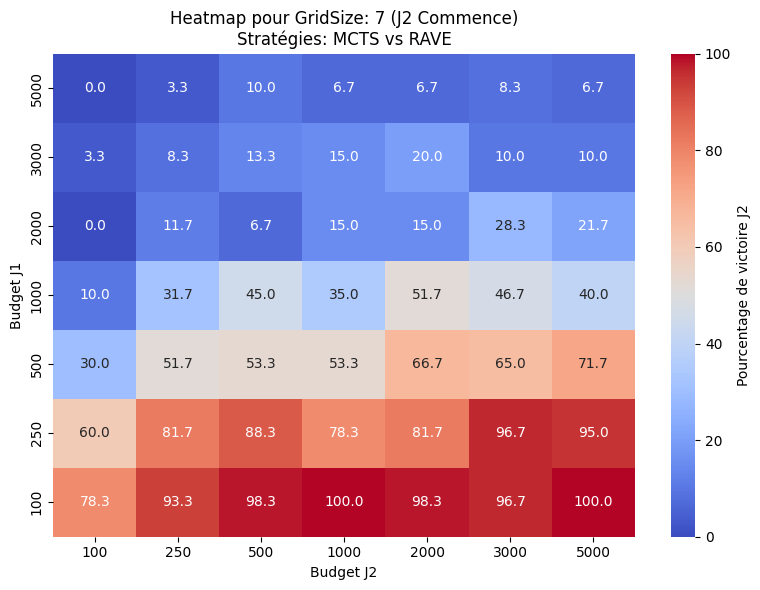

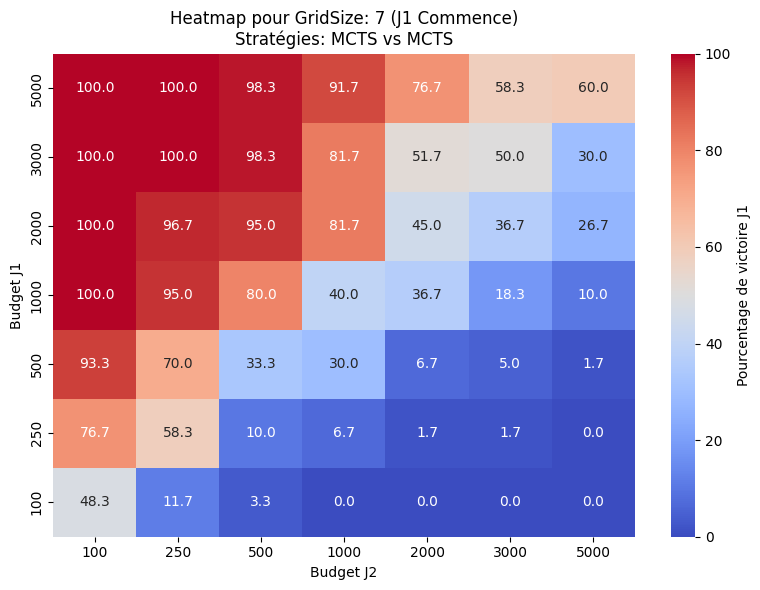

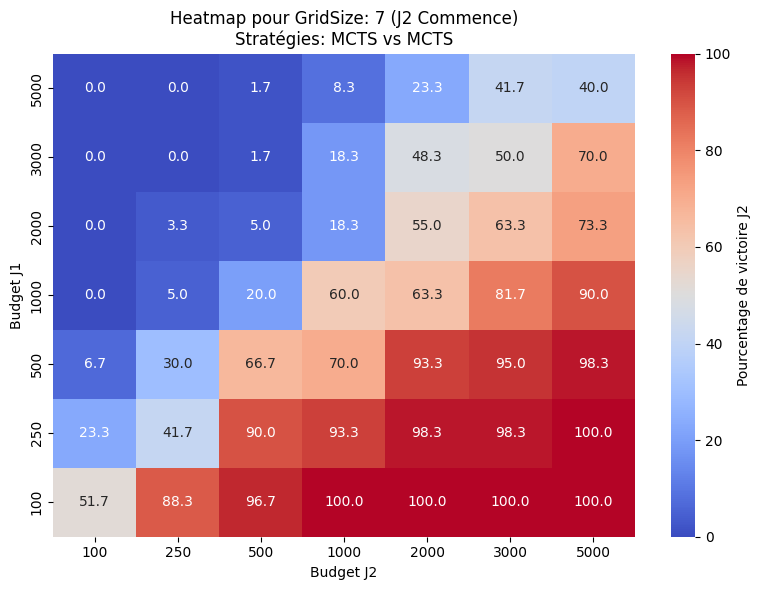

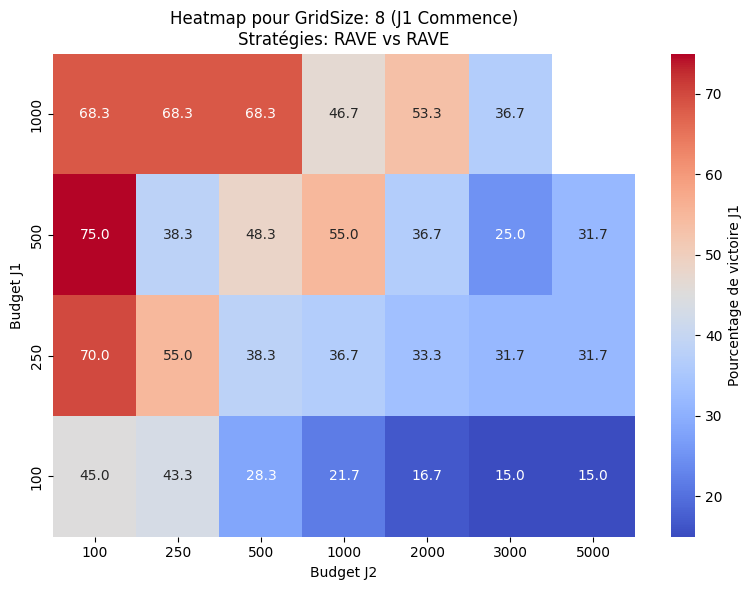

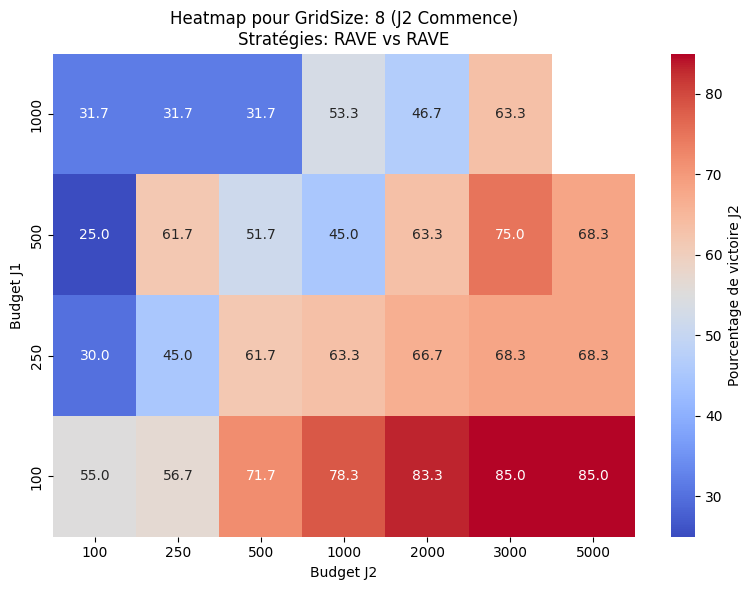

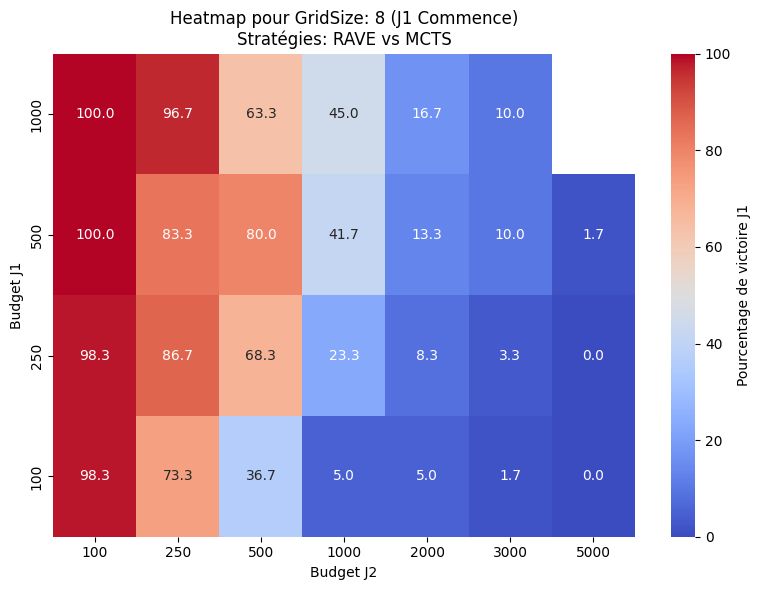

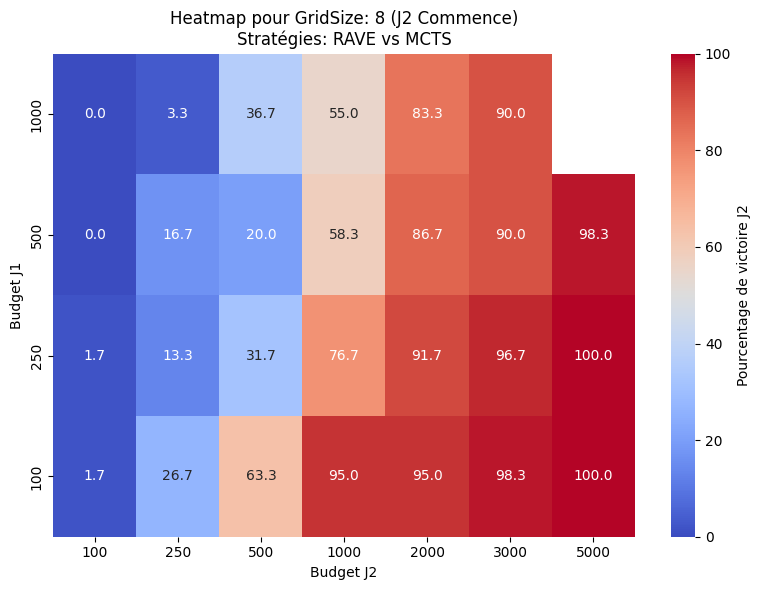

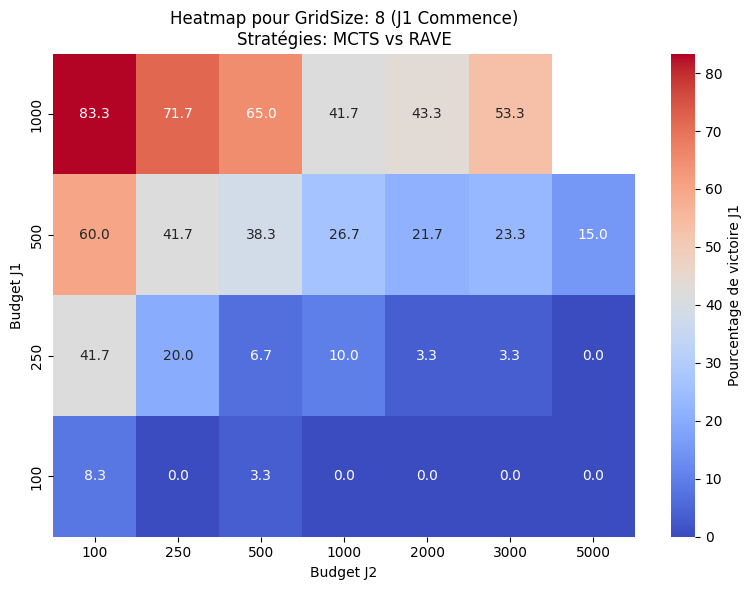

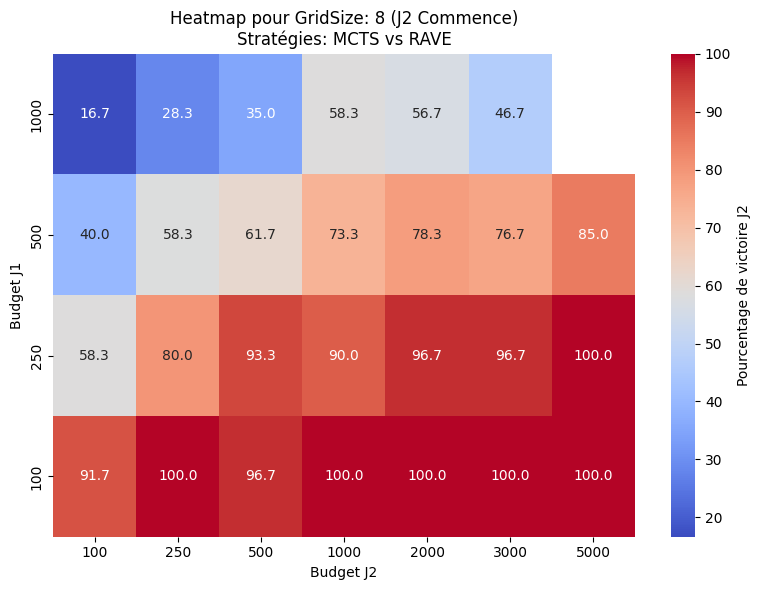

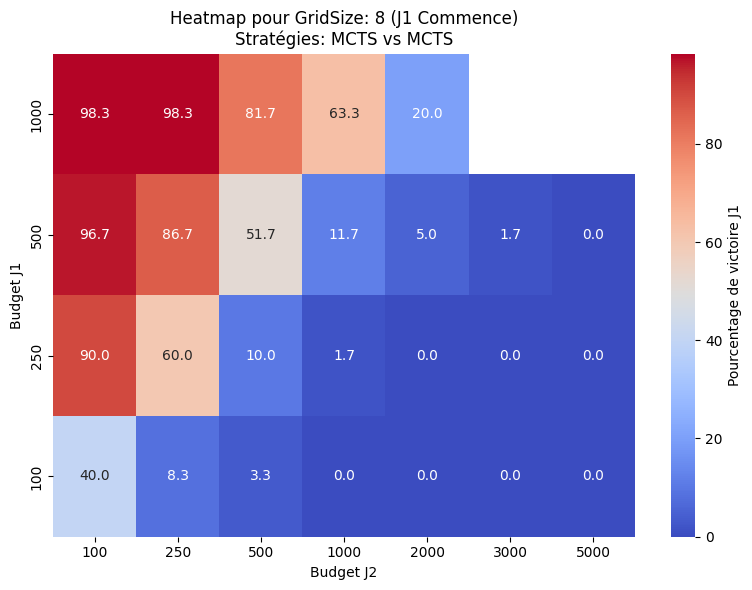

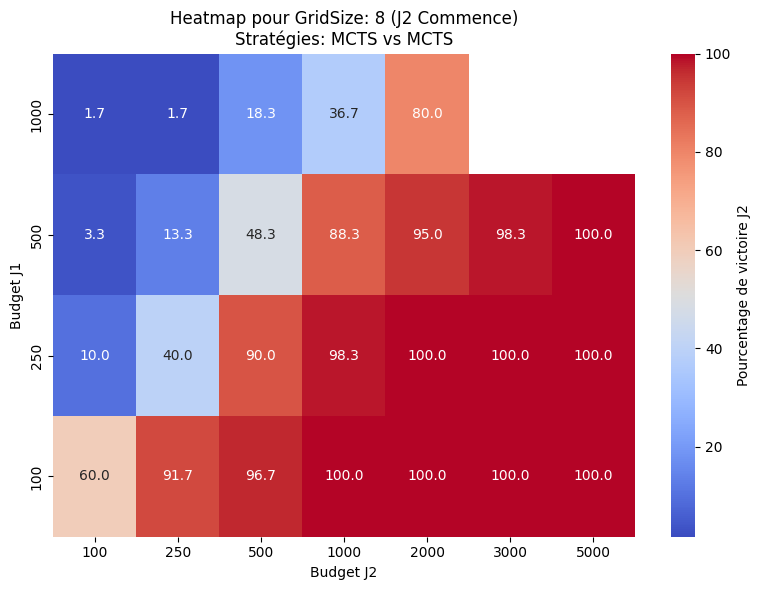

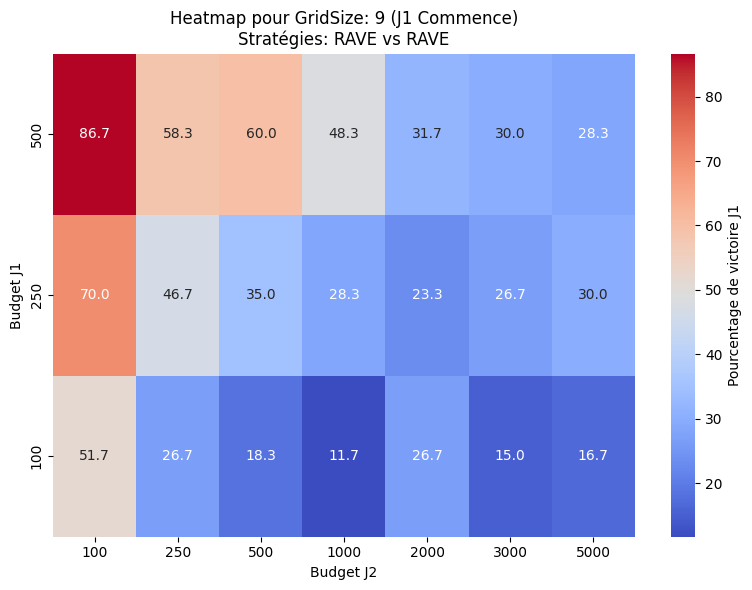

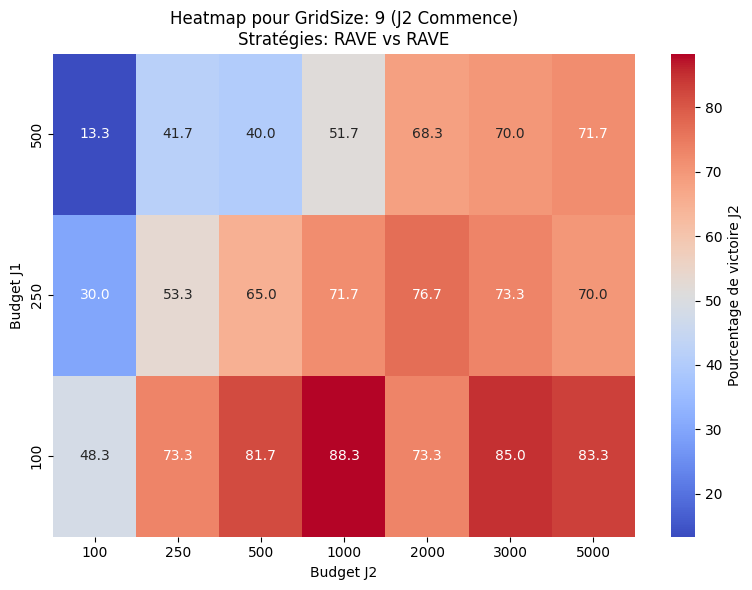

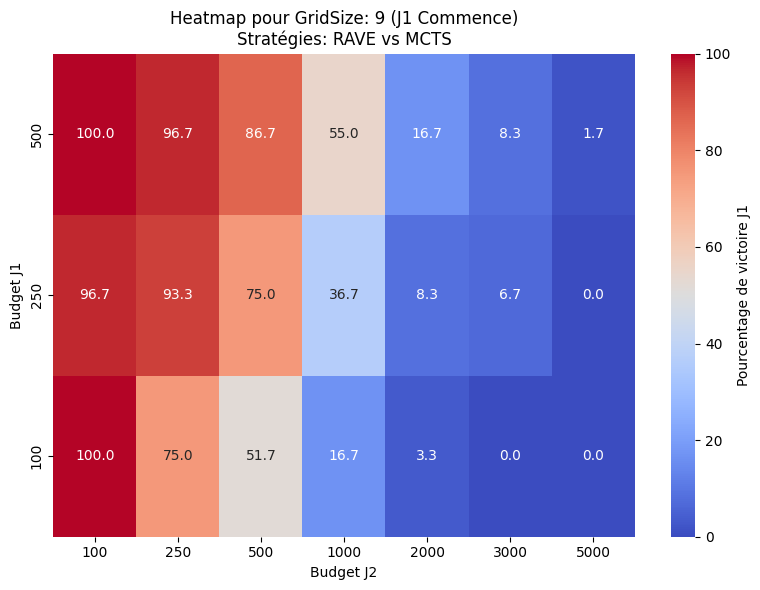

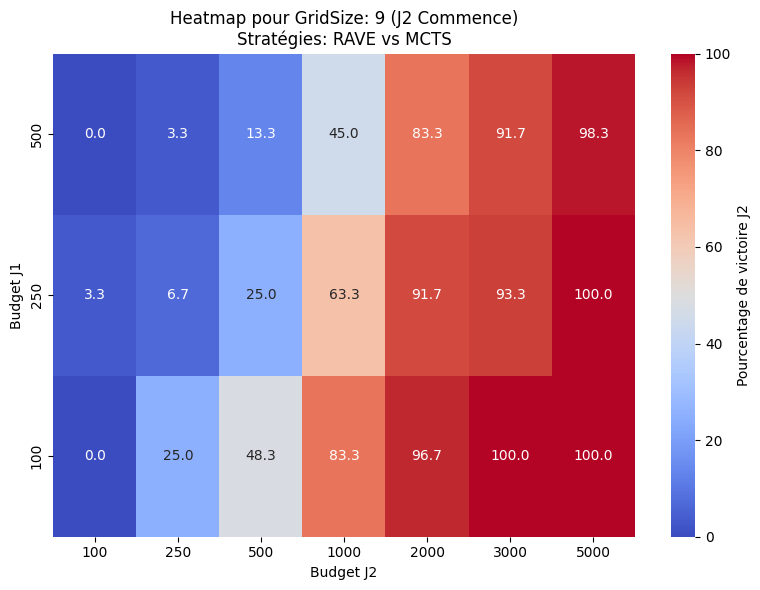

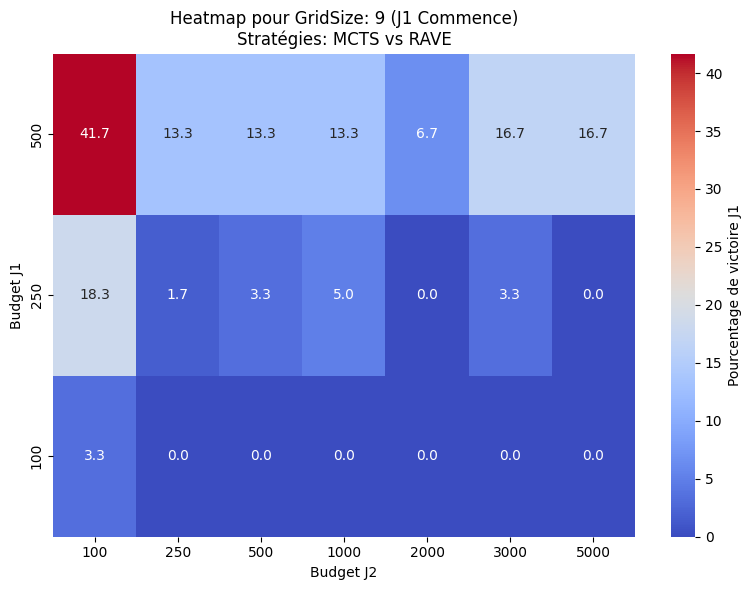

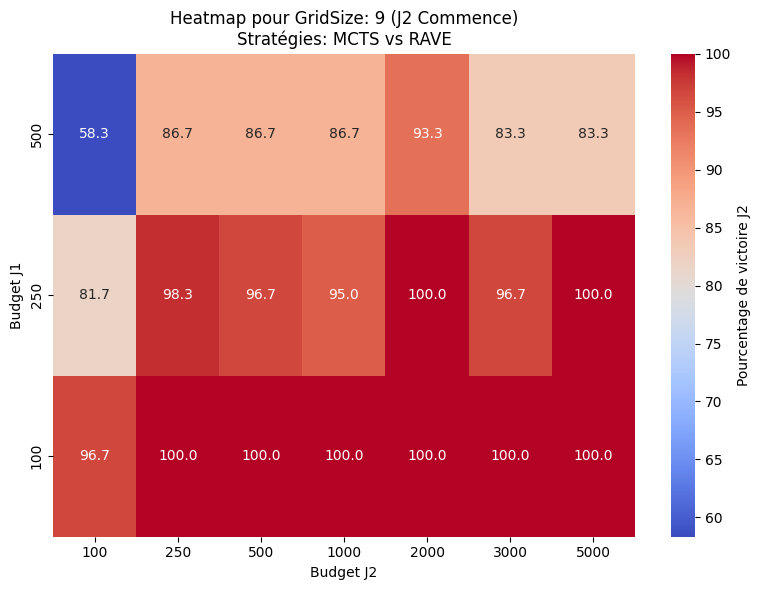

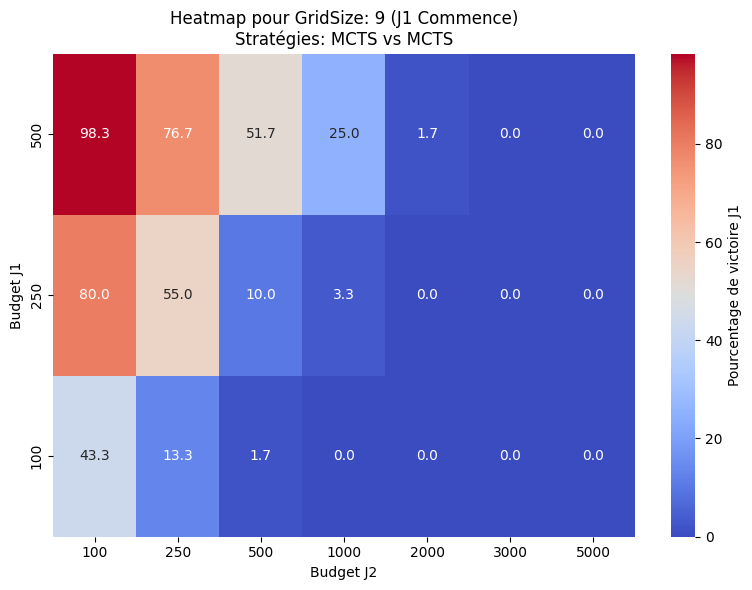

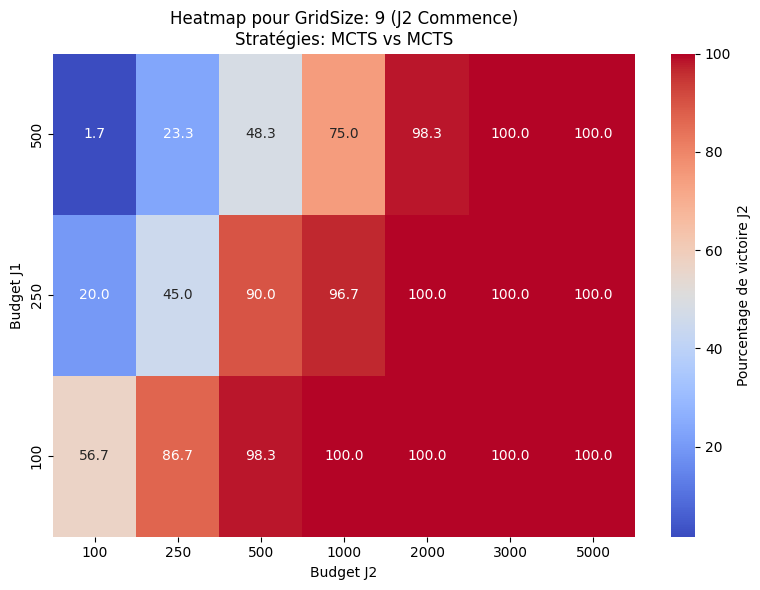

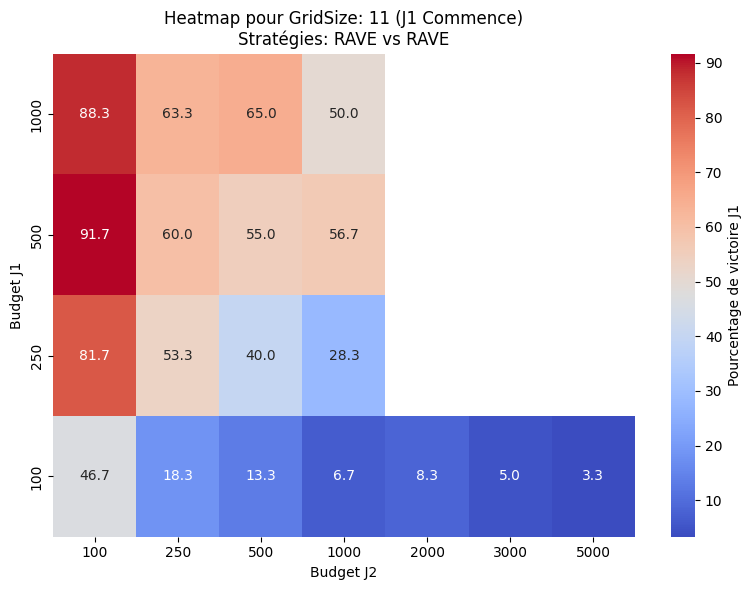

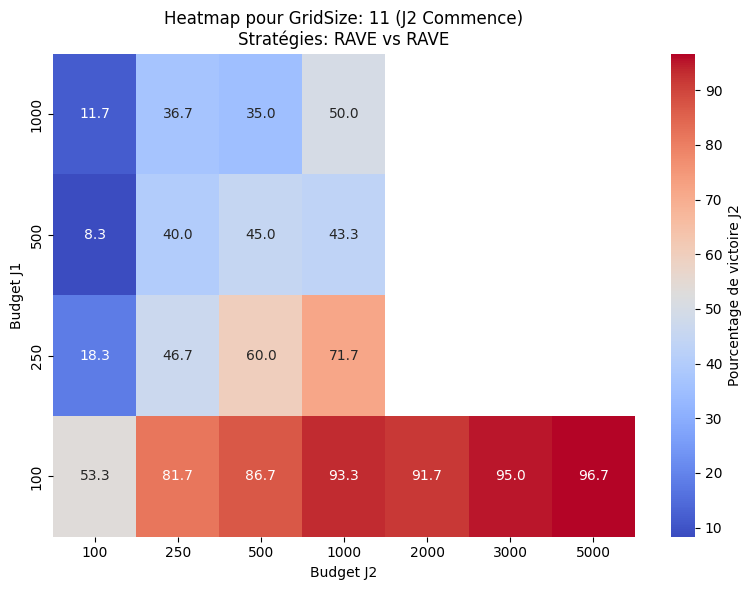

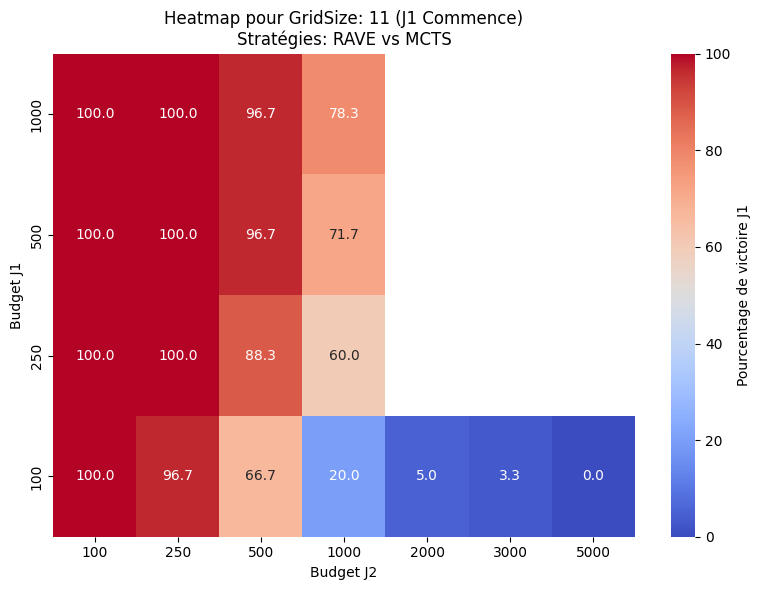

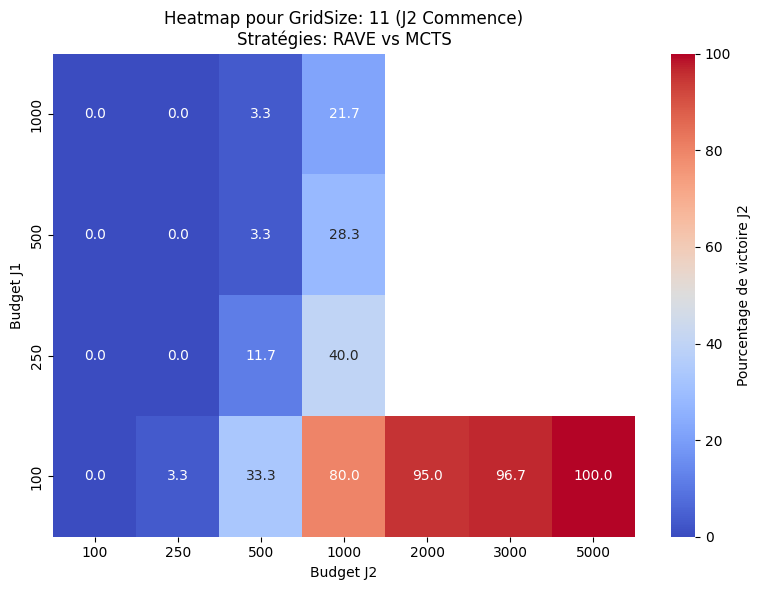

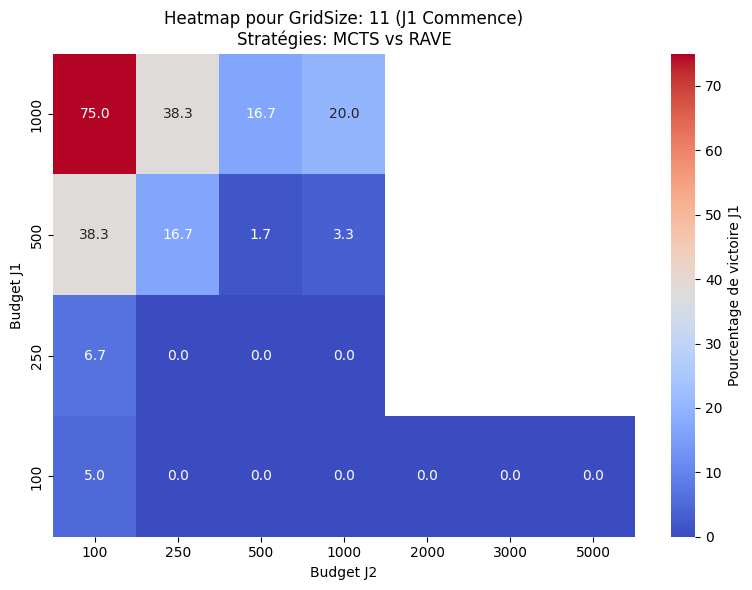

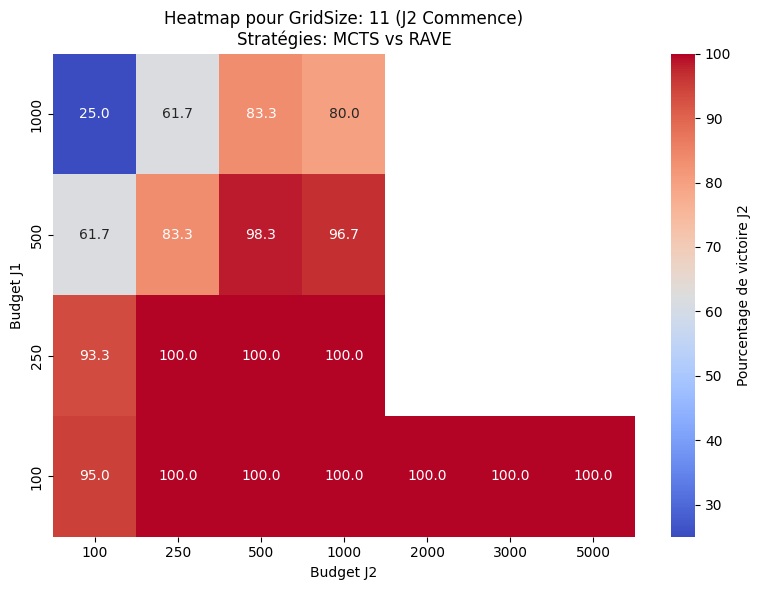

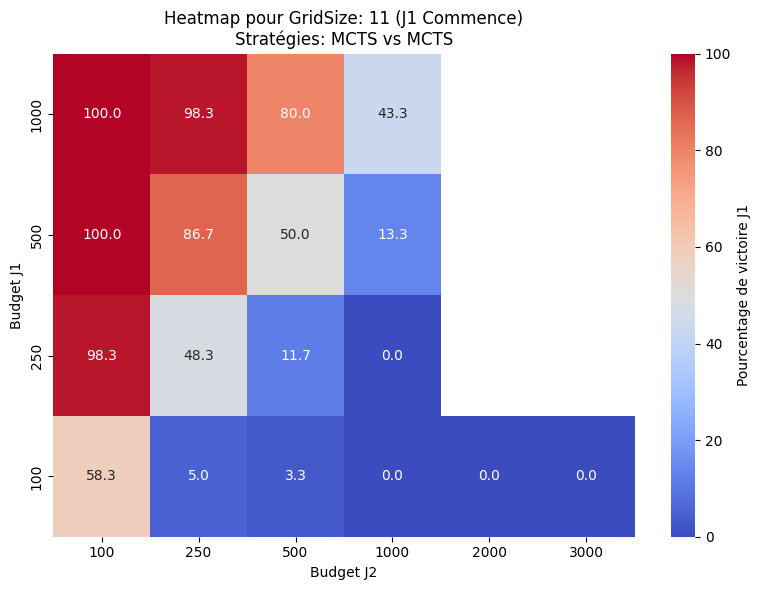

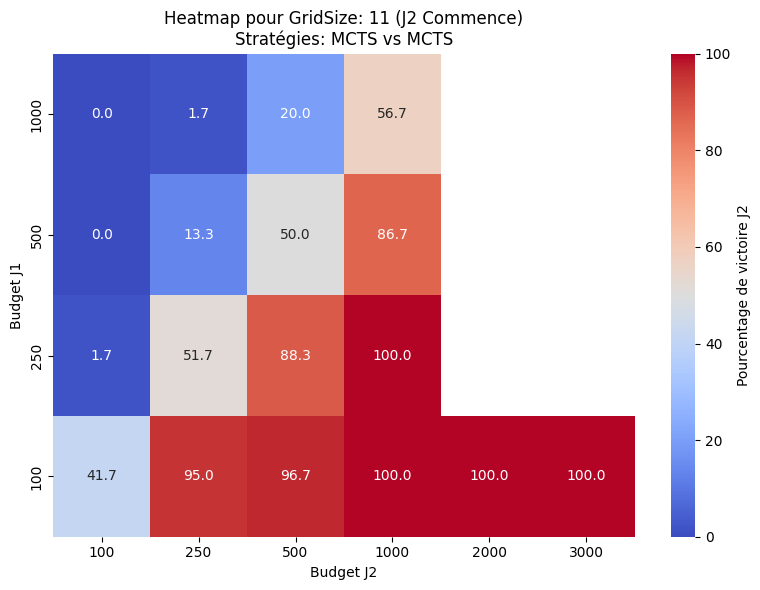

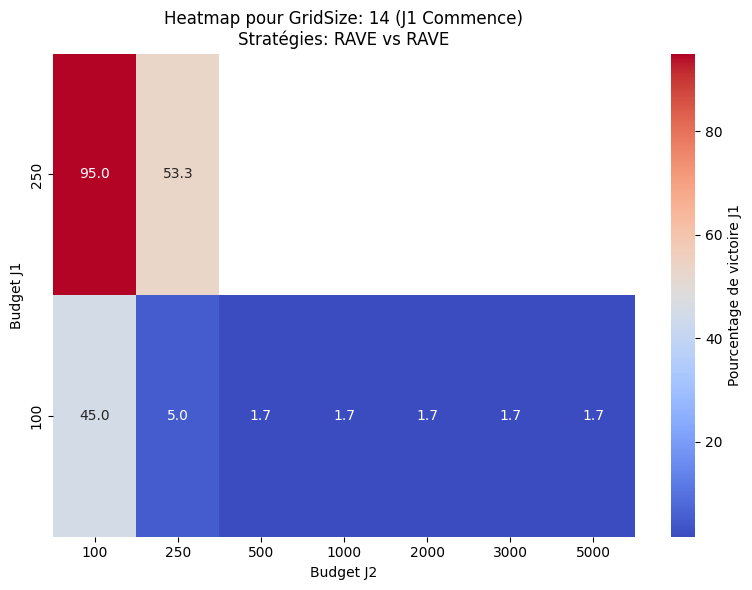

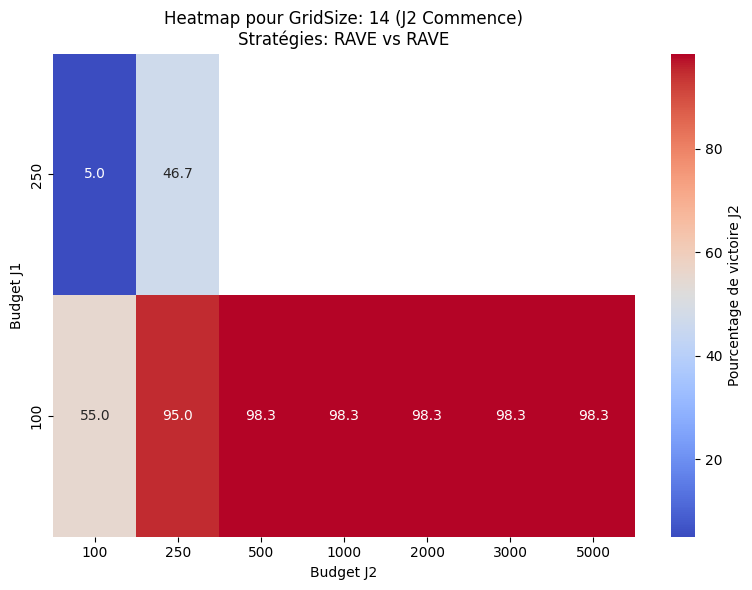

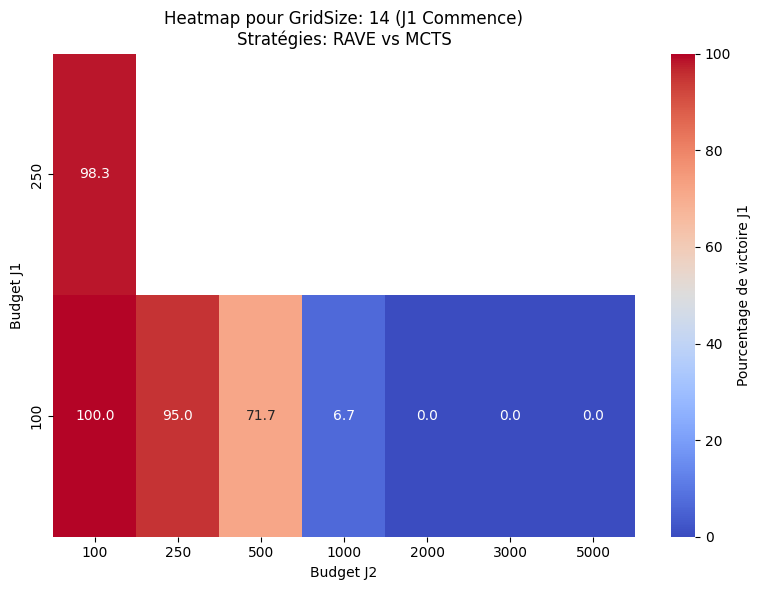

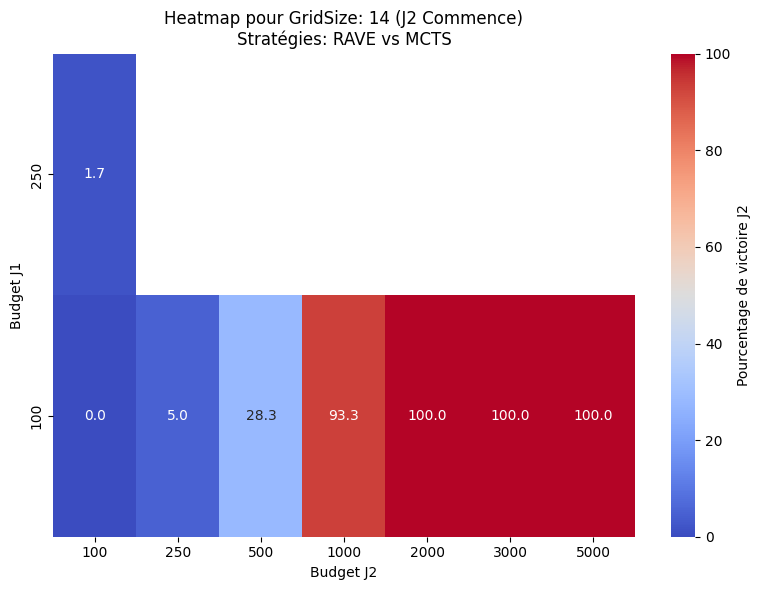

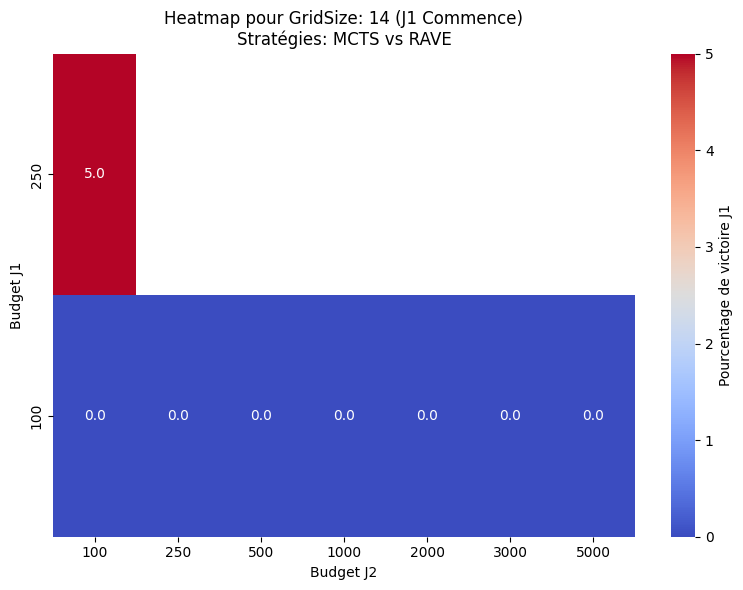

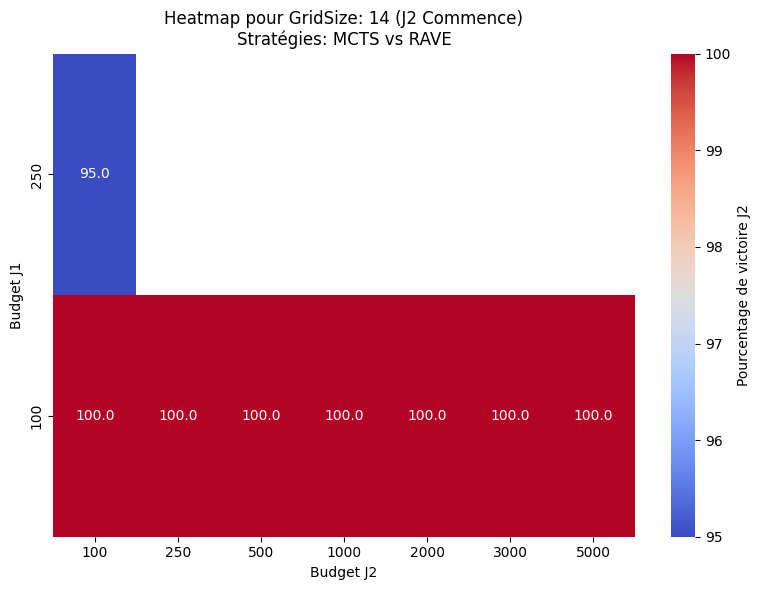

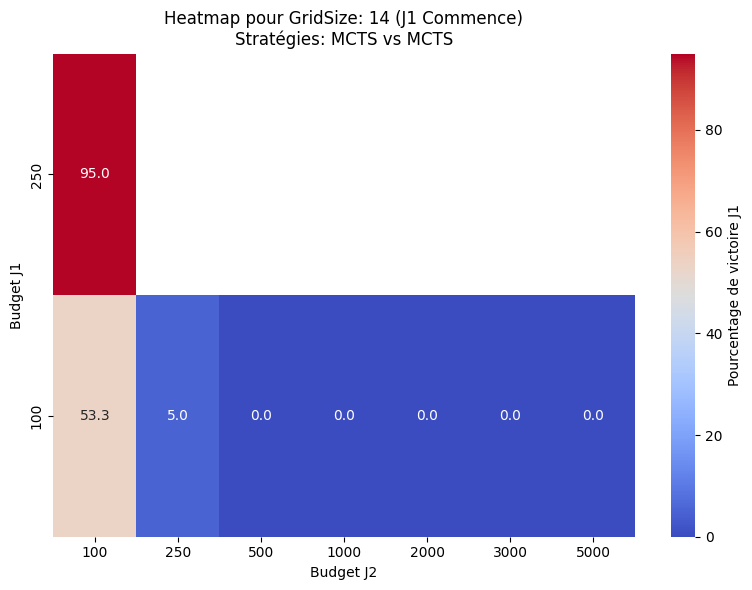

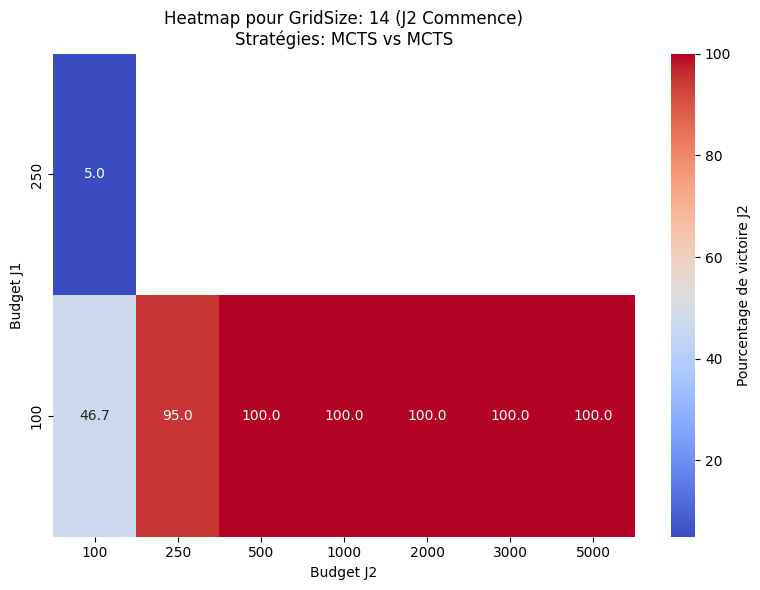

Graphiques générés pour chaque GridSize et chaque combinaison de stratégies.
Graphiques enregistrés dans grphs2/


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Create output directory if it doesn't exist
output_dir = "graphs"
os.makedirs(output_dir, exist_ok=True)

csv_files = glob.glob("results/*.csv")

def try_numeric(x):
    """Try to convert x to a numeric value; if unsuccessful, return x unchanged."""
    try:
        return pd.to_numeric(x)
    except Exception:
        return x

def read_and_preprocess(file):
    try:
        df = pd.read_csv(file)
        
        # Process the "GridSize" column to handle combined grids (e.g., "5-6-7-8-9")
        if "GridSize" in df.columns:
            def split_grids(val):
                if isinstance(val, str) and "-" in val:
                    try:
                        return [int(x.strip()) for x in val.split("-")]
                    except Exception:
                        return [val]
                else:
                    try:
                        return [int(val)]
                    except Exception:
                        return [val]
            
            df["GridSize"] = df["GridSize"].apply(split_grids)
            df = df.explode("GridSize")
            df["GridSize"] = df["GridSize"].apply(try_numeric)
        return df
    except Exception as e:
        print(f"Erreur lors de la lecture de {file} : {e}")
        return None

if not csv_files:
    print("Aucun fichier CSV trouvé dans le dossier results/")
else:
    dataframes = []
    for file in csv_files:
        df = read_and_preprocess(file)
        if df is not None:
            dataframes.append(df)
    
    if dataframes:
        # Concatenate all dataframes
        data = pd.concat(dataframes, ignore_index=True)
        
        # Do NOT filter by strategy to allow different strategies for players.
        # Get unique grid sizes and sort them
        grid_sizes = sorted(data["GridSize"].unique())
        
        # Iterate over each grid size
        for grid_size in grid_sizes:
            grid_subset = data[data["GridSize"] == grid_size]
            
            # Get unique strategy combinations in the current grid size
            strat_pairs = grid_subset[['StrategieJ1', 'StrategieJ2']].drop_duplicates()
            
            for _, row in strat_pairs.iterrows():
                strat1 = row['StrategieJ1']
                strat2 = row['StrategieJ2']
                
                # Filter subset for the specific strategies
                sub = grid_subset[(grid_subset["StrategieJ1"] == strat1) & (grid_subset["StrategieJ2"] == strat2)]
                
                # Check if necessary columns exist before pivoting
                if 'BudgetJ1' not in sub.columns or 'BudgetJ2' not in sub.columns:
                    continue
                
                # For "J1 Commence": pivot using PourcentageJ1
                if 'PourcentageJ1' in sub.columns:
                    pivot_j1 = sub.pivot_table(
                        index='BudgetJ1',
                        columns='BudgetJ2',
                        values='PourcentageJ1'
                    )
                    
                    # Generate heatmap for J1 Commence
                    plt.figure(figsize=(8, 6))
                    ax1 = sns.heatmap(
                        pivot_j1,
                        annot=True,
                        fmt=".1f",
                        cmap="coolwarm",
                        cbar_kws={'label': 'Pourcentage de victoire J1'}
                    )
                    ax1.invert_yaxis()  # lower budgets at the top
                    title_j1 = f"Heatmap pour GridSize: {grid_size} (J1 Commence)\nStratégies: {strat1} vs {strat2}"
                    plt.title(title_j1)
                    plt.xlabel("Budget J2")
                    plt.ylabel("Budget J1")
                    plt.tight_layout()
                    
                    file_j1 = os.path.join(output_dir, f"heatmap_grille_{grid_size}_J1_{strat1}_vs_{strat2}.png")
                    plt.savefig(file_j1)
                    plt.show()  # Display the figure in Jupyter
                    plt.close()
                else:
                    print("Colonne 'PourcentageJ1' introuvable pour GridSize:", grid_size, "et stratégies:", strat1, strat2)
                
                # For "J2 Commence": pivot using PourcentageJ2
                if 'PourcentageJ2' in sub.columns:
                    pivot_j2 = sub.pivot_table(
                        index='BudgetJ1',
                        columns='BudgetJ2',
                        values='PourcentageJ2'
                    )
                    
                    # Generate heatmap for J2 Commence
                    plt.figure(figsize=(8, 6))
                    ax2 = sns.heatmap(
                        pivot_j2,
                        annot=True,
                        fmt=".1f",
                        cmap="coolwarm",
                        cbar_kws={'label': 'Pourcentage de victoire J2'}
                    )
                    ax2.invert_yaxis()
                    title_j2 = f"Heatmap pour GridSize: {grid_size} (J2 Commence)\nStratégies: {strat1} vs {strat2}"
                    plt.title(title_j2)
                    plt.xlabel("Budget J2")
                    plt.ylabel("Budget J1")
                    plt.tight_layout()
                    
                    file_j2 = os.path.join(output_dir, f"heatmap_grille_{grid_size}_J2_{strat1}_vs_{strat2}.png")
                    plt.savefig(file_j2)
                    #plt.show()  # Display the figure in Jupyter
                    plt.close()
                else:
                    print("Colonne 'PourcentageJ2' introuvable pour GridSize:", grid_size, "et stratégies:", strat1, strat2)
                    
        print("Graphiques générés pour chaque GridSize et chaque combinaison de stratégies.")
        print(f"Graphiques enregistrés dans {output_dir}/")